In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter


use_cuda = torch.cuda.is_available()


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [2]:
data_dir = '../data/raw/airlinersnet/'
batch_size = 10
feature_extract=True

In [3]:
# Data loading and normalization for training
norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

data_transforms = {
    'train':transforms.Compose([
       transforms.Resize(240),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*norm)
    ]),
    'valid':transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(*norm)
    ]),
     'test':transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(*norm)
    ]),
}

# Load the datasets with ImageFolder
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

# Dataloaders
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}



In [4]:
import json
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)

class_names = [cat_to_name[x] for x in image_datasets['train'].classes]

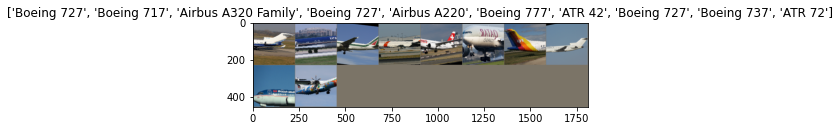

In [5]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:

model_transfer = models.densenet161(pretrained=True)

num_classes = len(image_datasets['train'])
num_features = model_transfer.classifier.in_features
input_size = model_transfer.classifier.state_dict()[next(iter(model_transfer.classifier.state_dict()))].size(1)
hidden_units = int(input_size/2)


model_transfer.classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_units)),
                            ('relu', nn.ReLU()),
                            ('drop', nn.Dropout(0.4)),
                            ('fc2', nn.Linear(hidden_units, num_classes))
]))
    

if use_cuda:
    model_transfer = model_transfer.cuda()

In [7]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    # Tensorboard writer
    writer = SummaryWriter()
    """returns trained model"""
    writer.flush()
    
    print('Training for {} epochs on {}\n'.format(n_epochs, 'GPU' if use_cuda else 'CPU'))
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    losses = {'train':[], 'validation':[]}
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx+1))*(loss.data-train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += ((1/(batch_idx+1))*(loss.data-valid_loss))
                ## update the average validation loss

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Valid", valid_loss, epoch)


        ## TODO: save the model if validation loss has decreased
        if valid_loss<valid_loss_min:
            print('Saving model', save_path)
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # plotting losses
    plt.plot(losses['train'], label='Training Loss')
    plt.plot(losses['validation'], label='Validation Loss')
    plt.legend()
    _ = plt.ylim()
    
    # return trained model
    return model


In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [9]:
def predict(img_path, model):

    img = Image.open(img_path)

    inputs = transform(img).unsqueeze(dim=0)

    model.eval()

    with torch.no_grad():
        if use_cuda:
            inputs = inputs.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    model.train()

    
    return preds.cpu().numpy()[0]

In [10]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

In [11]:
#model_transfer = train(50, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_densenet_sgd_50_airlinersnet.pt')


In [12]:
model_transfer.load_state_dict(torch.load('model_densenet_sgd_50_airlinersnet.pt'))

<All keys matched successfully>

In [13]:
test(dataloaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.144945


Test Accuracy: 96% (3300/3415)


In [14]:


transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
                                                        
def predict_aircraft(img_path):
    idx = predict(img_path, model_transfer)
    return class_names[idx]

In [15]:
def plot_image(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

def caption_images(img_path):
    print(f"This looks like a: {predict_aircraft(img_path)}")
    plot_image(img_path)
    

In [16]:
from glob import glob
import numpy as np
import random
import cv2

In [17]:
extra_test_img_dir = glob("../data/processed/test_images/*")

This looks like a: Boeing 707
This looks like a: Boeing 727
This looks like a: Airbus A300


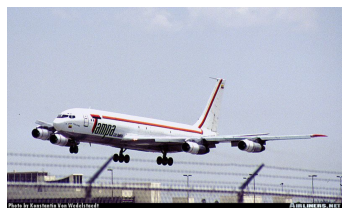

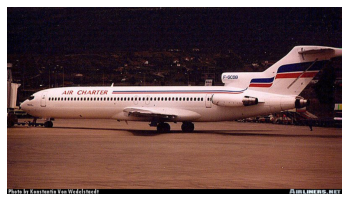

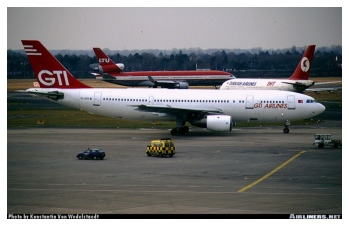

In [18]:
for i in random.sample(list(extra_test_img_dir),3):
    caption_images(i)